In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
X = pd.read_csv('preprocessed_features.csv')
y = pd.read_csv('target_variable.csv').values.ravel()

In [9]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Creating preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Creating a pipeline that includes preprocessing
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [14]:
# Applying SMOTE to handle class imbalance. It was applied after preprocessing to ensure all data is numerical
X_train_preprocessed = preprocessor.fit_transform(X_train)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

In [15]:
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)

In [16]:
# Grid search with cross-validation
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train) 

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best cross-validation score: 1.0


In [17]:
y_pred = grid_search.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14907
           1       1.00      1.00      1.00      8971

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



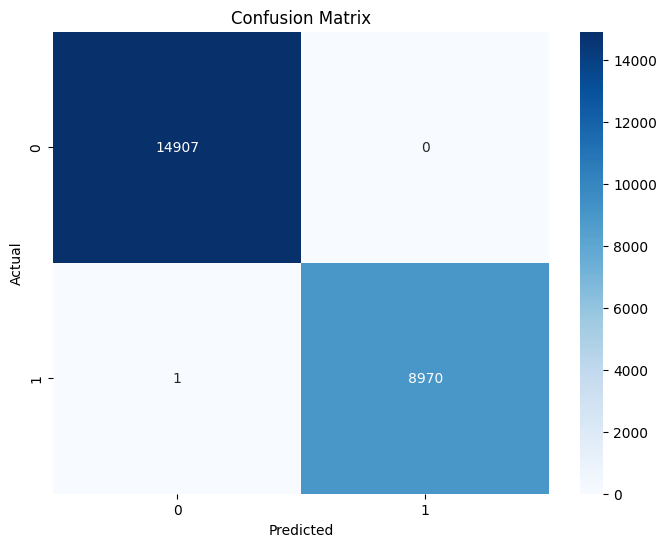

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
# Getting the feature names from the ColumnTransformer
feature_names = []
for name, transformer, features in grid_search.best_estimator_.named_steps['preprocessor'].transformers_:
    if name == 'num':
        feature_names.extend(features)
    elif name == 'cat':
        ohe = transformer.named_steps['onehot']
        feature_names.extend(ohe.get_feature_names_out())

feature_importance = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

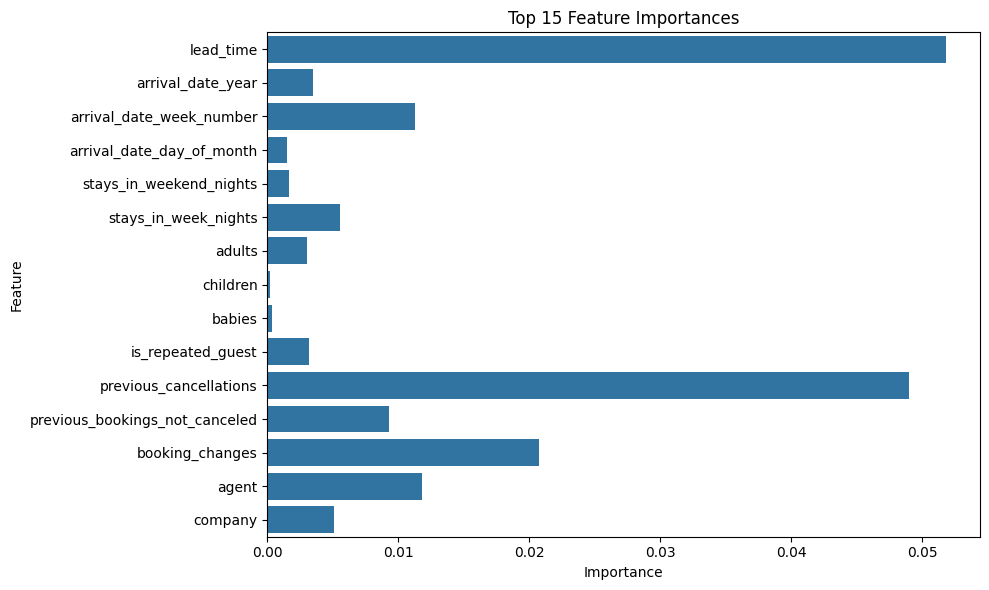


Model improvement process completed!


In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nModel improvement process completed!")